In [82]:
%matplotlib inline

import pandas as pd
from GeoBases import GeoBase
import matplotlib.pyplot as plt

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

print "Let's start the challenge! "

Let's start the challenge! 


In [9]:
bookings = pd.read_csv('data/bookings.csv.bz2', sep='^', compression='bz2', usecols=['arr_port','pax'], nrows=1000)
print "The number of rows of bookings file is %s" % len(bookings)

The number of rows of bookings file is 1000


In [99]:
dateparse = lambda x: pd.datetime.strptime(x.strip(), '%Y-%m-%d')
searches = pd.read_csv('data/searches.csv.bz2', sep='^', compression='bz2', parse_dates=True, date_parser=dateparse,
                       usecols=['Destination','Date'], index_col='Date', nrows=1000000)
print "The number of rows of searches file is %s" % len(searches)

The number of rows of searches file is 1000000


In [68]:
best10airports = bookings.groupby('arr_port').aggregate(sum).sort_index(by='pax', ascending=False).head(10)
print best10airports

          pax
arr_port     
DCA        50
JFK        14
FLL        13
PVG        13
CGK        12
LGA        12
SVO        12
LAS        11
BOS        11
MIA        11


In [39]:
print "What are the names of these airports?"
geo_a = GeoBase(data='airports', verbose=False)
for (arp,pax) in best10airports.iterrows():
    print "%s --> %s" % (arp, geo_a.get(arp.strip(), 'name'))  

What are the names of these airports?
DCA      --> Ronald Reagan Washington National Airport
JFK      --> John F Kennedy International Airport
FLL      --> Fort Lauderdale-Hollywood International Airport
PVG      --> Shanghai / Pudong
CGK      --> Jakarta / Soekarno-Hatta
LGA      --> La Guardia Airport
SVO      --> Aeroport Sheremet'yevo
LAS      --> McCarran International Airport
BOS      --> General Edward Lawrence Logan International Airport
MIA      --> Miami International Airport


In [47]:
print geo_a.fuzzyFind('Malaga','name')[0]
print geo_a.fuzzyFind('Madrid','name')[0]
print geo_a.fuzzyFind('Barcelona','name')[0]

(0.9, 'AGP')
(0.9, 'MAD')
(0.9, 'BCN')


In [100]:
is_malaga = searches['Destination'] == "AGP"
is_madrid = searches['Destination'] == "MAD"
is_barcelona = searches['Destination'] == "BCN"
searches_filtered = searches[is_malaga | is_madrid | is_barcelona]
searches_filtered.loc[:,'Month'] = searches_filtered.index.month
print "The number of rows of searches filtered is %s" % len(searches_filtered)

The number of rows of searches filtered is 33685


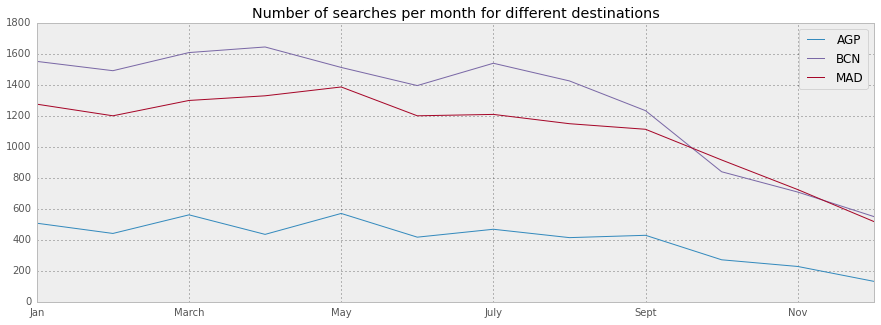

In [110]:
fig, ax = plt.subplots()
for arp, df in searches_filtered.groupby('Destination'):
    monthlySearches = df.groupby('Month').size()
    monthlySearches.index = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov', 'Dec']
    monthlySearches.plot(kind="line", x='Month', legend='Number of searches', ax=ax, label=arp, 
                         title='Number of searches per month for different destinations' )
plt.legend()